In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-11-08 13:14:17.130273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 13:14:17.130312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    

In [8]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

2021-11-08 13:14:19.526194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-08 13:14:19.526492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 13:14:19.526529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-08 13:14:19.526557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-08 13:14:19.526583: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [10]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}




In [11]:
variance_scales = np.logspace(-2,2,20)

In [12]:
parameters = ['T_serial', 'rho_M', 'lambda_M', 'nu_M',
              'warmup_asymp_-3', 'warmup_asymp_-1', 'warmup_asymp_-1'
]

trials = 5

losses = {}
for parameter in parameters:
    
    
    
    key = parameter
    losses[key] = []
    
    T_serial_scale = 1.0
    rho_M_scale = 0.1
    lambda_M_scale = 1.0
    nu_M_scale = 1.2
    
    warmup_scales = [0.1, 0.1, 0.1]
    
    

    
    
    
    for var_scale in variance_scales:
        
        if key =='T_serial':
            T_serial_scale =T_serial_scale *var_scale
        if key =='rho_M':
            rho_M_scale = rho_M_scale *var_scale
        if key =='lambda_M':
            lambda_M_scale =  lambda_M_scale *var_scale
        if key =='nu_M':
            nu_M_scale =nu_M_scale*var_scale
        if key =='warmup_asymp_-3':
            warmup_scales[0] = warmup_scales[0]*var_scale
        if key =='warmup_asymp_-2':
            warmup_scales[1] = warmup_scales[1]*var_scale
        if key =='warmup_asymp_-1':
            warmup_scales[2] = warmup_scales[2]*var_scale
            
        for trial in range(trials):
            
            T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

            rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(synth_rho_M/(1-synth_rho_M)),dtype=tf.float32),
                                                  'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

            lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_lambda_M),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}
            
            nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(synth_nu_M),dtype=tf.float32),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

            for day in range(transition_window):
                # must be positive so reverse softplus the mean
                warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                                     'scale': tf.cast(tfp.math.softplus_inverse(warmup_scales[day]),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

            model = CovidModel([Vax.total], [Comp.A, Comp.M],
                             transition_window,
                            T_serial, rho_M, lambda_M, nu_M,
                             warmup_A_params, posterior_samples=1000)
            
            loss = LogPoissonProb() 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
            )
            
            with tf.GradientTape() as tape:
                model._constrain_parameters()
                model._sample_and_reparameterize()
                model._add_prior_loss()
                loss_val = sum(model.losses)
                
            losses[key].append(loss_val)

2021-11-08 13:14:21.776719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Text(0.5, 1.0, 'Asymptomatic Compartment')

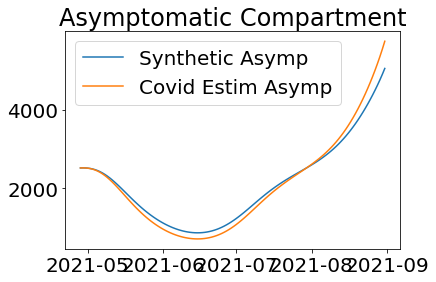

In [13]:
plt.plot(df.loc[warmup_start:test_end].index.values, A_vals, label='Synthetic Asymp')
plt.plot(df.loc[warmup_start:test_end].index.values, df.loc[warmup_start:test_end,'asymp'].values, label='Covid Estim Asymp')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Asymptomatic Compartment')

Text(0.5, 1.0, 'Mild Compartment')

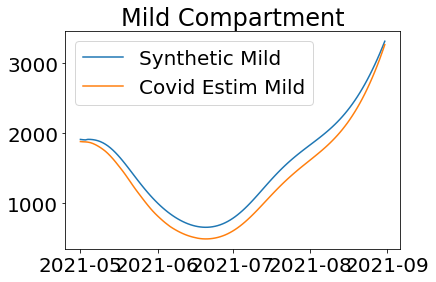

In [14]:
plt.plot(df.loc[train_start:test_end].index.values, M_vals, label='Synthetic Mild')
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end,'mild'].values, label='Covid Estim Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

([<matplotlib.axis.XTick at 0x7fbd2c15a590>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

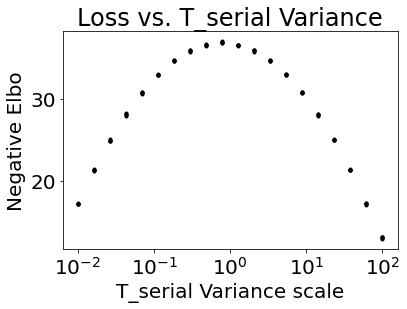

In [15]:
plt.plot(np.repeat(variance_scales,trials),
         losses['T_serial'], 'k.')
plt.xlabel('T_serial Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. T_serial Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])

([<matplotlib.axis.XTick at 0x7fbd0c4ba690>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

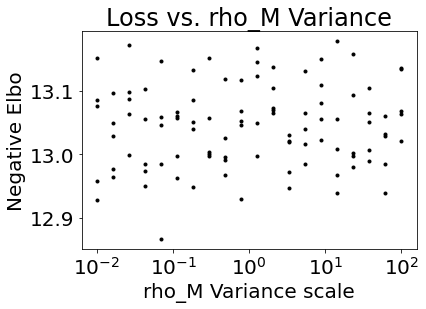

In [16]:
plt.plot(np.repeat(variance_scales,trials),
         losses['rho_M'], 'k.')
plt.xlabel('rho_M Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. rho_M Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])

([<matplotlib.axis.XTick at 0x7fbd2c6bc3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

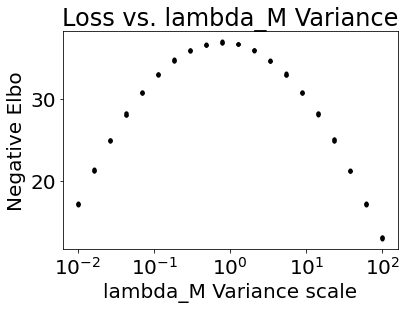

In [17]:
plt.plot(np.repeat(variance_scales,trials),
         losses['lambda_M'], 'k.')
plt.xlabel('lambda_M Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. lambda_M Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])

([<matplotlib.axis.XTick at 0x7fbcec4eadd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

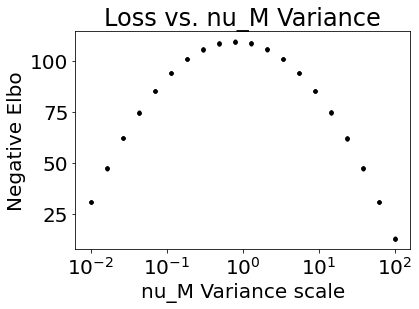

In [18]:
plt.plot(np.repeat(variance_scales,trials),
         losses['nu_M'], 'k.')
plt.xlabel('nu_M Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. nu_M Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])

([<matplotlib.axis.XTick at 0x7fbd0c202810>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

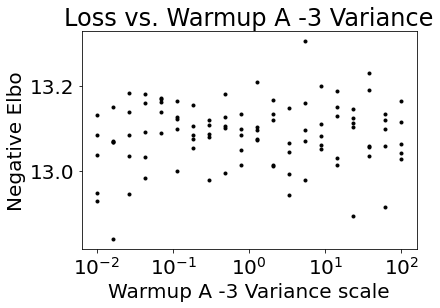

In [19]:
plt.plot(np.repeat(variance_scales,trials),
         losses['warmup_asymp_-3'], 'k.')
plt.xlabel('Warmup A -3 Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. Warmup A -3 Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])

([<matplotlib.axis.XTick at 0x7fbd2c46d3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

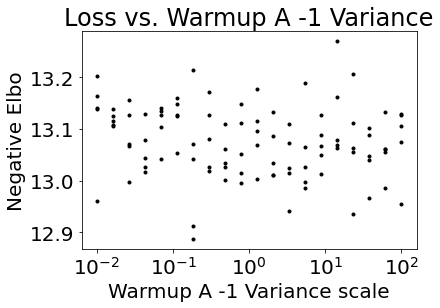

In [21]:
plt.plot(np.repeat(variance_scales,trials),
         losses['warmup_asymp_-1'], 'k.')
plt.xlabel('Warmup A -1 Variance scale')
plt.ylabel('Negative Elbo')
plt.title("Loss vs. Warmup A -1 Variance")
plt.xscale('log')
plt.xticks([0.01, 0.1, 1, 10, 100])